In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterstats import zonal_stats
import rasterio
import os

# =============================================================================
# 1. CONFIG: PATHS
# =============================================================================

# High‑res NUTS‑2 GeoJSON from GISCO (01M, 2024, EPSG:3035)
nuts_path = "../NUTS_RG_01M_2024_3035_LEVL_2.geojson"

# Define ALL 14 Rasters in a specific ordered list (to ensure correct sorting later)
# Tuples: (Scenario Name, File Path, Sort Order)
# Sort Order: 1-7 for 2041, 8-14 for 2071
all_rasters_config = [
    # Period 2041–2070
    ("ssp119_2041_2070", "../raw_data/koppen_geiger_2041_ssp119.tif", 1),
    ("ssp126_2041_2070", "../raw_data/koppen_geiger_2041_ssp126.tif", 2),
    ("ssp245_2041_2070", "../raw_data/koppen_geiger_2041_ssp245.tif", 3),
    ("ssp370_2041_2070", "../raw_data/koppen_geiger_2041_ssp370.tif", 4),
    ("ssp434_2041_2070", "../raw_data/koppen_geiger_2041_ssp434.tif", 5),
    ("ssp460_2041_2070", "../raw_data/koppen_geiger_2041_ssp460.tif", 6),
    ("ssp585_2041_2070", "../raw_data/koppen_geiger_2041_ssp585.tif", 7),

    # Period 2071–2099
    ("ssp119_2071_2099", "../raw_data/koppen_geiger_2071_ssp119.tif", 8),
    ("ssp126_2071_2099", "../raw_data/koppen_geiger_2071_ssp126.tif", 9),
    ("ssp245_2071_2099", "../raw_data/koppen_geiger_2071_ssp245.tif", 10),
    ("ssp370_2071_2099", "../raw_data/koppen_geiger_2071_ssp370.tif", 11),
    ("ssp434_2071_2099", "../raw_data/koppen_geiger_2071_ssp434.tif", 12),
    ("ssp460_2071_2099", "../raw_data/koppen_geiger_2071_ssp460.tif", 13),
    ("ssp585_2071_2099", "../raw_data/koppen_geiger_2071_ssp585.tif", 14),
]

# =============================================================================
# 2. LOAD NUTS‑2
# =============================================================================

nuts = gpd.read_file(nuts_path)
nuts_2 = nuts[nuts["LEVL_CODE"] == 2].copy()

print(f"Loaded {len(nuts_2)} NUTS‑2 regions.")
print(f"NUTS CRS: {nuts_2.crs}")

# =============================================================================
# 3. KÖPPEN LEGEND (from legend.txt)
# =============================================================================

koppen_legend = {
    1: 'Af', 2: 'Am', 3: 'Aw',
    4: 'BWh', 5: 'BWk', 6: 'BSh', 7: 'BSk',
    8: 'Csa', 9: 'Csb', 10: 'Csc',
    11: 'Cwa', 12: 'Cwb', 13: 'Cwc',
    14: 'Cfa', 15: 'Cfb', 16: 'Cfc',
    17: 'Dsa', 18: 'Dsb', 19: 'Dsc', 20: 'Dsd',
    21: 'Dwa', 22: 'Dwb', 23: 'Dwc', 24: 'Dwd',
    25: 'Dfa', 26: 'Dfb', 27: 'Dfc', 28: 'Dfd',
    29: 'ET', 30: 'EF'
}

# =============================================================================
# 4. CORE FUNCTION: ONE SCENARIO -> ONE GEO-DATAFRAME
# =============================================================================

def compute_koppen_by_nuts2(nuts_gdf, raster_path, scenario_name, sort_order):
    """Return GeoDataFrame with pct_<Köppen> columns for each NUTS‑2 region
    for a given SSP raster."""
    if not os.path.exists(raster_path):
        print(f"⚠ WARNING: Raster not found: {raster_path}. Skipping.")
        return None

    print(f"\n=== Scenario: {scenario_name} (Order: {sort_order}) ===")
    print(f"Raster: {raster_path}")

    # Ensure CRS alignment with raster
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs
        # Check if re-projection is needed (only once per file)
        if nuts_gdf.crs != raster_crs:
            print("Reprojecting NUTS‑2 to raster CRS...")
            nuts_local = nuts_gdf.to_crs(raster_crs)
        else:
            nuts_local = nuts_gdf.copy()

    # Zonal statistics – categorical (counts per climate class)
    print("Running zonal_stats (categorical=True)...")
    stats = zonal_stats(
        nuts_local,
        raster_path,
        categorical=True,
        nodata=0,
        all_touched=False
    )

    climate_df = pd.DataFrame(stats).fillna(0)

    # Total pixels per region
    climate_df["total_pixels"] = climate_df.sum(axis=1)

    # Build percentage columns for every Koppen class (0–1)
    pct_data = {}
    for code, name in koppen_legend.items():
        col = code
        if col in climate_df.columns:
            pct_data[f"pct_{name}"] = (
                climate_df[col].astype(float) / climate_df["total_pixels"].replace(0, np.nan)
            ).fillna(0.0)
        else:
            # Region has 0 pixels of this class
            pct_data[f"pct_{name}"] = 0.0

    pct_df = pd.DataFrame(pct_data)

    # Combine with NUTS identifiers and geometry
    out_gdf = pd.concat(
        [
            nuts_local[["NUTS_ID", "NUTS_NAME", "CNTR_CODE"]].reset_index(drop=True),
            pct_df.reset_index(drop=True)
        ],
        axis=1
    )

    out_gdf["scenario"] = scenario_name
    out_gdf["sort_order"] = sort_order # Helper for final sorting

    return out_gdf

# =============================================================================
# 5. RUN FOR ALL 14 RASTERS & CONSOLIDATE
# =============================================================================

dfs_to_concat = []

for scen_name, tif_path, order in all_rasters_config:
    # Compute for this scenario
    df_scen = compute_koppen_by_nuts2(nuts_2, tif_path, scen_name, order)

    if df_scen is not None:
        dfs_to_concat.append(df_scen)

# Concatenate into one master DataFrame
master_ssp_df = pd.concat(dfs_to_concat, ignore_index=True)

# SORTING:
# 1. Sort by NUTS_ID (Group regions together)
# 2. Sort by 'sort_order' (Ensure 2041 SSP1 -> 2041 SSP5 -> 2071 SSP1 -> 2071 SSP5)
master_ssp_df = master_ssp_df.sort_values(by=['NUTS_ID', 'sort_order'])

# Reorder columns: ID, Name, Scenario, ...Climate Pcts...
cols = ['NUTS_ID', 'NUTS_NAME', 'scenario'] + [c for c in master_ssp_df.columns if c.startswith('pct_')]
master_ssp_df = master_ssp_df[cols]

print("\n=== CONSOLIDATION COMPLETE ===")
print(f"Master DataFrame Shape: {master_ssp_df.shape}")
print(f"Rows per Region: {master_ssp_df.groupby('NUTS_ID').size().mean()}") # Should be 14.0

# Verify Sorting
print("\nSample Rows (First Region):")
print(master_ssp_df.head(14)[['NUTS_ID', 'scenario']])

# Save
# master_ssp_df.to_csv("NUTS2_SSP_Projections_14_Scenarios_Ranked.csv", index=False)
# print("✓ Saved to 'NUTS2_SSP_Projections_14_Scenarios_Ranked.csv'")


Loaded 299 NUTS‑2 regions.
NUTS CRS: EPSG:3035

=== Scenario: ssp119_2041_2070 (Order: 1) ===
Raster: ../raw_data/koppen_geiger_2041_ssp119.tif
Reprojecting NUTS‑2 to raster CRS...
Running zonal_stats (categorical=True)...

=== Scenario: ssp126_2041_2070 (Order: 2) ===
Raster: ../raw_data/koppen_geiger_2041_ssp126.tif
Reprojecting NUTS‑2 to raster CRS...
Running zonal_stats (categorical=True)...

=== Scenario: ssp245_2041_2070 (Order: 3) ===
Raster: ../raw_data/koppen_geiger_2041_ssp245.tif
Reprojecting NUTS‑2 to raster CRS...
Running zonal_stats (categorical=True)...

=== Scenario: ssp370_2041_2070 (Order: 4) ===
Raster: ../raw_data/koppen_geiger_2041_ssp370.tif
Reprojecting NUTS‑2 to raster CRS...
Running zonal_stats (categorical=True)...

=== Scenario: ssp434_2041_2070 (Order: 5) ===
Raster: ../raw_data/koppen_geiger_2041_ssp434.tif
Reprojecting NUTS‑2 to raster CRS...
Running zonal_stats (categorical=True)...

=== Scenario: ssp460_2041_2070 (Order: 6) ===
Raster: ../raw_data/koppen

In [6]:
master_ssp_df.head(15)

,NUTS_ID,NUTS_NAME,scenario,pct_Af,pct_Am,pct_Aw,pct_BWh,pct_BWk,pct_BSh,pct_BSk,...,pct_Dwa,pct_Dwb,pct_Dwc,pct_Dwd,pct_Dfa,pct_Dfb,pct_Dfc,pct_Dfd,pct_ET,pct_EF
25,AL01,Veri,ssp119_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226688,0.015828,0.0,0.0,0.0
324,AL01,Veri,ssp126_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.202027,0.010730,0.0,0.0,0.0
623,AL01,Veri,ssp245_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.176063,0.008536,0.0,0.0,0.0
922,AL01,Veri,ssp370_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.155077,0.005572,0.0,0.0,0.0
1221,AL01,Veri,ssp434_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.141384,0.008477,0.0,0.0,0.0
1520,AL01,Veri,ssp460_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.162132,0.006106,0.0,0.0,0.0
1819,AL01,Veri,ssp585_2041_2070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.145415,0.001956,0.0,0.0,0.0
2118,AL01,Veri,ssp119_2071_2099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.234809,0.020748,0.0,0.0,0.0
2417,AL01,Veri,ssp126_2071_2099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.184065,0.013220,0.0,0.0,0.0
2716,AL01,Veri,ssp245_2071_2099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.150868,0.003142,0.0,0.0,0.0


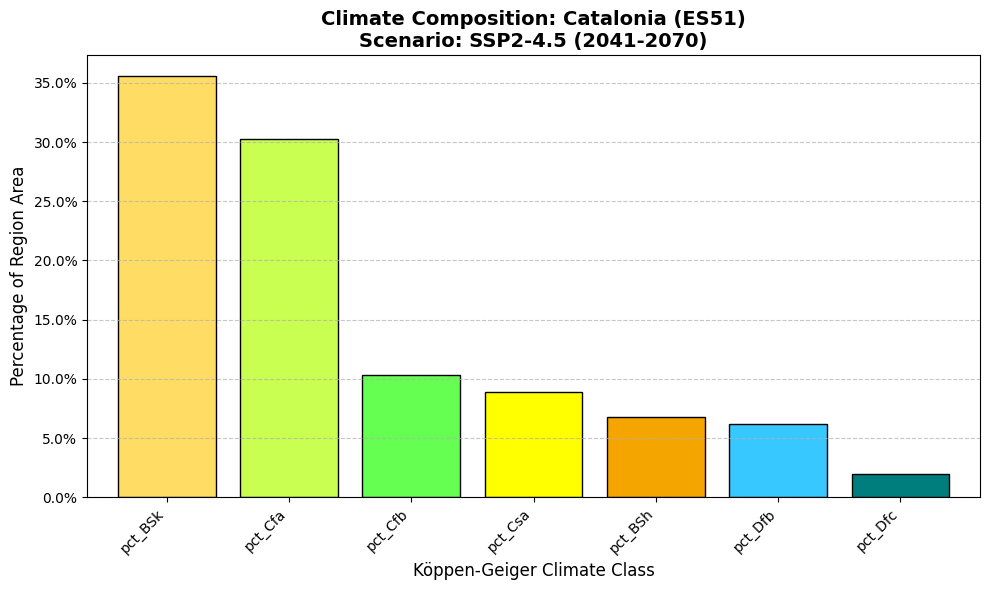

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# =============================================================================
# VISUALIZATION: CATALONIA (ES51) FOR SSP2-4.5 (2041-2070)
# =============================================================================

target_region = "ES51"
target_scenario = "ssp245_2041_2070"

# Filter the master dataframe for the specific region and scenario
# 'master_ssp_df' is the final dataframe from the previous step
subset = master_ssp_df[
    (master_ssp_df['NUTS_ID'] == target_region) &
    (master_ssp_df['scenario'] == target_scenario)
].copy()

if not subset.empty:
    # Get the first (and only) row
    climate_dist = subset.iloc[0]

    # Filter for climate percentage columns only
    climate_cols = [c for c in climate_dist.index if c.startswith('pct_')]
    climate_dist = climate_dist[climate_cols]

    # Filter for climates with >1% presence and sort
    climate_dist = climate_dist[climate_dist > 0.01].sort_values(ascending=False)

    # 2. Define Köppen-Geiger Colors (Beck et al., 2018)
    koppen_colors = {
        'Af':  [0, 0, 255],    'Am':  [0, 120, 255],  'Aw': [70, 170, 250],
        'BWh': [255, 0, 0],    'BWk': [255, 150, 150],'BSh': [245, 165, 0],
        'BSk': [255, 220, 100],'Csa': [255, 255, 0],  'Csb': [200, 200, 0],
        'Csc': [150, 150, 0],  'Cwa': [150, 255, 150],'Cwb': [100, 200, 100],
        'Cwc': [50, 150, 50],   'Cfa': [200, 255, 80], 'Cfb': [100, 255, 80],
        'Cfc': [50, 200, 0],    'Dsa': [255, 0, 255],  'Dsb': [200, 0, 200],
        'Dsc': [150, 50, 150],  'Dsd': [150, 100, 150],'Dwa': [170, 175, 255],
        'Dwb': [90, 120, 220],  'Dwc': [75, 80, 180],  'Dwd': [50, 0, 135],
        'Dfa': [0, 255, 255],   'Dfb': [55, 200, 255], 'Dfc': [0, 125, 125],
        'Dfd': [0, 70, 95],     'ET': [178, 178, 178],'EF': [102, 102, 102]
    }

    # Create list of colors for the plot
    bar_colors = []
    for col_name in climate_dist.index:
        class_name = col_name.replace('pct_', '')
        rgb = koppen_colors.get(class_name, [128, 128, 128]) # Default grey
        bar_colors.append([val / 255.0 for val in rgb])

    # 3. Create the Bar Chart
    plt.figure(figsize=(10, 6))

    ax = climate_dist.plot(
        kind='bar',
        color=bar_colors,
        edgecolor='black',
        width=0.8
    )

    plt.title(f'Climate Composition: Catalonia ({target_region})\nScenario: SSP2-4.5 (2041-2070)', fontsize=14, fontweight='bold')
    plt.ylabel('Percentage of Region Area', fontsize=12)
    plt.xlabel('Köppen-Geiger Climate Class', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    plt.tight_layout()
    plt.show()

else:
    print(f"Scenario {target_scenario} for region {target_region} not found.")


In [15]:
master_ssp_df.to_csv("NUTS2_SSP_Baseline_Projections.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np

# 1. Load your CSV file
# Replace 'your_2020_data.csv' with your actual file path
df = pd.read_csv('raw_data/2020_base.csv')

# 2. Define the columns to keep
# We explicitly select these and drop everything else (like pct_*, nights_spent, etc.)
columns_to_keep = [
    'geo', 'NUTS_NAME', 'year',
    'pop', 'gdp_capita', 'employment_rate',
    'area_km2', 'pop_dens'
]

# Filter the dataframe to only these columns
df_clean = df[columns_to_keep].copy()

# 3. Deduplicate to handle the "7 of the same entries" issue
# This ensures we have exactly one base row per region for 2020
df_clean = df_clean.drop_duplicates(subset=['geo'])

# 4. Define projection settings
base_year = 2020
target_years = [2055, 2085]

# Growth rates (0.5% = 0.005, 1% = 0.01)
pop_growth_rate = 0.005
gdp_growth_rate = 0.01

# List to store all dataframes (base + projections)
all_data = []

# --- Process Base Year (2020) ---
# We recalculate pop_dens just to ensure consistency
df_2020 = df_clean.copy()
df_2020['pop_dens'] = df_2020['pop'] / df_2020['area_km2']
all_data.append(df_2020)

# --- Process Future Years (2055, 2085) ---
for year in target_years:
    df_future = df_clean.copy()

    # Calculate number of years passed since 2020
    years_passed = year - base_year

    # Set the new year
    df_future['year'] = year

    # Apply Compound Growth Formula: Future = Present * (1 + rate)^years
    df_future['pop'] = df_future['pop'] * ((1 + pop_growth_rate) ** years_passed)
    df_future['gdp_capita'] = df_future['gdp_capita'] * ((1 + gdp_growth_rate) ** years_passed)

    # Employment rate and Area stay constant (no change needed)

    # Recalculate Population Density with new population
    df_future['pop_dens'] = df_future['pop'] / df_future['area_km2']

    all_data.append(df_future)

# 5. Combine and Sort
final_df = pd.concat(all_data, ignore_index=True)
final_df = final_df.sort_values(by=['geo', 'year'])

# 6. Save to CSV
final_df.to_csv('nuts2_projections_2020_2055_2085.csv', index=False)

# Optional: Print first few rows to verify
print("Processing complete. Output shape:", final_df.shape)
print(final_df.head(6))

Processing complete. Output shape: (741, 8)
      geo         NUTS_NAME  year           pop    gdp_capita  \
0    AT11        Burgenland  2020  2.944360e+05  29700.000000   
247  AT11        Burgenland  2055  3.505929e+05  42073.101854   
494  AT11        Burgenland  2085  4.071786e+05  56708.184699   
1    AT12  Niederösterreich  2020  1.684287e+06  35100.000000   
248  AT12  Niederösterreich  2055  2.005526e+06  49722.756737   
495  AT12  Niederösterreich  2085  2.329218e+06  67018.763735   

     employment_rate      area_km2    pop_dens  
0               75.4   3965.379817   74.251651  
247             75.4   3965.379817   88.413438  
494             75.4   3965.379817  102.683374  
1               77.6  19196.454858   87.739482  
248             77.6  19196.454858  104.473760  
495             77.6  19196.454858  121.335834  
